In [1]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import geopandas as gpd
import pandas as pd
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
from pyspark.sql.types import LongType
from shapely.geometry import Point
from shapely.geometry import Polygon

from geospark.register import GeoSparkRegistrator
from geospark.register import upload_jars
from geospark.core.SpatialRDD import SpatialRDD
from geospark.core.SpatialRDD import PointRDD
from geospark.core.SpatialRDD import PolygonRDD
from geospark.core.SpatialRDD import LineStringRDD
from geospark.core.enums import FileDataSplitter
from geospark.utils.adapter import Adapter
from geospark.core.spatialOperator import KNNQuery
from geospark.core.spatialOperator import JoinQuery
from geospark.core.spatialOperator import RangeQuery
from geospark.core.formatMapper.shapefileParser import ShapefileReader
from geospark.core.formatMapper import WkbReader
from geospark.core.formatMapper import WktReader
from geospark.core.formatMapper import GeoJsonReader
from geospark.sql.types import GeometryType
from geospark.core.enums import GridType
from geospark.core.SpatialRDD import RectangleRDD
from geospark.core.enums import IndexType
from geospark.core.geom.envelope import Envelope
from geospark.utils import GeoSparkKryoRegistrator, KryoSerializer

In [2]:
# This step is optional, if you have jar files already copied to $SPARK_HOME/jars,
# there is no need to use that function
upload_jars()

True

In [3]:
spark = SparkSession.\
    builder.\
    master("local[*]").\
    appName("GeoPySparkCoreExample").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", GeoSparkKryoRegistrator.getName) .\
    getOrCreate()

In [4]:
# Register function is essential for GeoSpark Core and GeoSparkSQL. 

In [5]:
GeoSparkRegistrator.registerAll(spark)

True

In [6]:
sc = spark.sparkContext

# Create SpatialRDD

## Reading to PointRDD from CSV file

Suppose we want load the CSV file into GeoSpark PointRDD
```
testattribute0,-88.331492,32.324142,testattribute1,testattribute2
testattribute0,-88.175933,32.360763,testattribute1,testattribute2
testattribute0,-88.388954,32.357073,testattribute1,testattribute2
testattribute0,-88.221102,32.35078,testattribute1,testattribute2
testattribute0,-88.323995,32.950671,testattribute1,testattribute2
testattribute0,-88.231077,32.700812,testattribute1,testattribute2
```

In [7]:
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, True, 10, StorageLevel.MEMORY_ONLY, "epsg:4326", "epsg:4326")

In [8]:
## Getting approximate total count
point_rdd.approximateTotalCount

3000

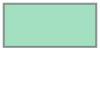

In [9]:
# getting boundary for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundary()

In [10]:
# To run analyze please use function analyze
point_rdd.analyze()

True

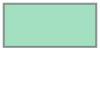

In [11]:
# Finding boundary envelope for PointRDD or any other SpatialRDD, it returns Enelope object which inherits from
# shapely.geometry.Polygon
point_rdd.boundaryEnvelope

In [12]:
# Calculate number of records without duplicates
point_rdd.countWithoutDuplicates()

2996

In [13]:
# Getting filed names for PointRDD or other SpatialRDD, it return list with field names
point_rdd.fieldNames

[]

In [14]:
# Geting source epsg code
point_rdd.getSourceEpsgCode()

'epsg:4326'

In [15]:
# Geting target epsg code
point_rdd.getTargetEpsgCode()

'epsg:4326'

In [16]:
# Spatial partitioning data
point_rdd.spatialPartitioning(GridType.EQUALGRID)

True

In [17]:
# Get PointRDD or other SpatialRDD, it returns list of Envelopes 
point_rdd.grids

In [18]:
# Spatial partitioning data
point_rdd.spatialPartitioning(GridType.VORONOI)

True

## Operations on RawSpatialRDD

rawSpatialRDD method returns RDD which consists of GeoData objects which has 2 attributes
<li> geom: shapely.geometry.BaseGeometry </li>
<li> userData: str </li>

You can use any operations on those objects and spread across machines

In [19]:
# take firs element
point_rdd.rawSpatialRDD.take(1)

[Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [20]:
# collect to Python list
point_rdd.rawSpatialRDD.collect()[:5]

[Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2,
 Geometry: Point userData: testattribute0	testattribute1	testattribute2]

In [21]:
# apply map functions, for example distance to Point(52 21)
point_rdd.rawSpatialRDD.map(lambda x: x.geom.distance(Point(21, 52))).take(5)

[111.08786851399313,
 110.92828303170774,
 111.1385974283527,
 110.97450594034112,
 110.97122518072091]

## Transforming to GeoPandas

## Loaded data can be transfomred to GeoPandas DataFrame few ways

### Directly from RDD

In [22]:
point_rdd_to_geo = point_rdd.rawSpatialRDD.map(lambda x: [x.geom, *x.getUserData().split("\t")])

In [23]:
point_gdf = gpd.GeoDataFrame(
    point_rdd_to_geo.collect(), columns=["geom", "attr1", "attr2", "attr3"], geometry="geom"
)

In [24]:
point_gdf[:5]

,geom,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


### Using Adapter

In [25]:
spatial_df = Adapter.\
    toDf(point_rdd, ["attr1", "attr2", "attr3"], spark).\
    createOrReplaceTempView("spatial_df")

spatial_gdf = spark.sql("Select attr1, attr2, attr3, st_GeomFromWKT(geometry) as geom from spatial_df")

In [26]:
spatial_gdf.show(5, False)

+--------------+--------------+--------------+----------------------------+
|attr1         |attr2         |attr3         |geom                        |
+--------------+--------------+--------------+----------------------------+
|testattribute0|testattribute1|testattribute2|POINT (-88.331492 32.324142)|
|testattribute0|testattribute1|testattribute2|POINT (-88.175933 32.360763)|
|testattribute0|testattribute1|testattribute2|POINT (-88.388954 32.357073)|
|testattribute0|testattribute1|testattribute2|POINT (-88.221102 32.35078) |
|testattribute0|testattribute1|testattribute2|POINT (-88.323995 32.950671)|
+--------------+--------------+--------------+----------------------------+
only showing top 5 rows



In [27]:
gpd.GeoDataFrame(spatial_gdf.toPandas(), geometry="geom")[:5]

,attr1,attr2,attr3,geom
0,testattribute0,testattribute1,testattribute2,POINT (-88.33149 32.32414)
1,testattribute0,testattribute1,testattribute2,POINT (-88.17593 32.36076)
2,testattribute0,testattribute1,testattribute2,POINT (-88.38895 32.35707)
3,testattribute0,testattribute1,testattribute2,POINT (-88.22110 32.35078)
4,testattribute0,testattribute1,testattribute2,POINT (-88.32399 32.95067)


### With DataFrame creation

In [28]:
schema = StructType(
    [
        StructField("geometry", GeometryType(), False),
        StructField("attr1", StringType(), False),
        StructField("attr2", StringType(), False),
        StructField("attr3", StringType(), False),
    ]
)

In [29]:
geo_df = spark.createDataFrame(point_rdd_to_geo, schema, verifySchema=False)

In [30]:
gpd.GeoDataFrame(geo_df.toPandas(), geometry="geometry")[:5]

,geometry,attr1,attr2,attr3
0,POINT (-88.33149 32.32414),testattribute0,testattribute1,testattribute2
1,POINT (-88.17593 32.36076),testattribute0,testattribute1,testattribute2
2,POINT (-88.38895 32.35707),testattribute0,testattribute1,testattribute2
3,POINT (-88.22110 32.35078),testattribute0,testattribute1,testattribute2
4,POINT (-88.32399 32.95067),testattribute0,testattribute1,testattribute2


# Load Typed SpatialRDDs

Currently The library supports 5 typed SpatialRDDs:
<li> RectangleRDD </li>
<li> PointRDD </li>
<li> PolygonRDD </li>
<li> LineStringRDD </li>
<li> CircleRDD </li>

In [31]:
rectangle_rdd = RectangleRDD(sc, "data/zcta510-small.csv", FileDataSplitter.CSV, True, 11)
point_rdd = PointRDD(sc, "data/arealm-small.csv", 1, FileDataSplitter.CSV, False, 11)
polygon_rdd = PolygonRDD(sc, "data/primaryroads-polygon.csv", FileDataSplitter.CSV, True, 11)
linestring_rdd = LineStringRDD(sc, "data/primaryroads-linestring.csv", FileDataSplitter.CSV, True, StorageLevel.MEMORY_ONLY)

In [32]:
rectangle_rdd.analyze()
point_rdd.analyze()
polygon_rdd.analyze()
linestring_rdd.analyze()

True

# Spatial Partitioning

GeoSpark spatial partitioning method can significantly speed up the join query. Three spatial partitioning methods are available: KDB-Tree, Quad-Tree and R-Tree. Two SpatialRDD must be partitioned by the same way.

In [33]:
point_rdd.spatialPartitioning(GridType.KDBTREE)

True

# Create Index

GeoSpark provides two types of spatial indexes, Quad-Tree and R-Tree. Once you specify an index type, GeoSpark will build a local tree index on each of the SpatialRDD partition.

In [34]:
point_rdd.buildIndex(IndexType.RTREE, True)

# SpatialJoin

Spatial join is operation which combines data based on spatial relations like:
<li> intersects </li>
<li> touches </li>
<li> within </li>
<li> etc </li>

To Use Spatial Join in GeoPyspark library please use JoinQuery object, which has implemented below methods:
```python
SpatialJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

DistanceJoinQuery(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

spatialJoin(queryWindowRDD: SpatialRDD, objectRDD: SpatialRDD, joinParams: JoinParams) -> RDD

DistanceJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

SpatialJoinQueryFlat(spatialRDD: SpatialRDD, queryRDD: SpatialRDD, useIndex: bool, considerBoundaryIntersection: bool) -> RDD

```

## Example SpatialJoinQueryFlat PointRDD with RectangleRDD 

In [35]:
# partitioning the data
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())
# building an index
point_rdd.buildIndex(IndexType.RTREE, True)
# Perform Spatial Join Query
result = JoinQuery.SpatialJoinQueryFlat(point_rdd, rectangle_rdd, False, True)

As result we will get RDD[GeoData, GeoData]
It can be used like any other Python RDD. You can use map, take, collect and other functions  

In [36]:
result

MapPartitionsRDD[72] at map at GeoSerializerData.scala:142

In [37]:
result.take(2)

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [38]:
result.collect()[:3]

[[Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ],
 [Geometry: Polygon userData: , Geometry: Point userData: ]]

In [39]:
# getting distance useing SpatialObjects
result.map(lambda x: x[0].geom.distance(x[1].geom)).take(5)

[0.0, 0.0, 0.0, 0.0, 0.0]

In [40]:
# getting area of polygon data
result.map(lambda x: x[0].geom.area).take(5)

[0.054270513955000516,
 0.054270513955000516,
 0.051572544132000575,
 0.051572544132000575,
 0.051572544132000575]

In [41]:
# Base on result you can create DataFrame object, using map function and buld DataFrame from RDD

In [42]:
schema = StructType(
    [
        StructField("geom_left", GeometryType(), False),
        StructField("geom_right", GeometryType(), False)
    ]
)

In [43]:
# Set verifySchema to False
spatial_join_result = result.map(lambda x: [x[0].geom, x[1].geom])
spark.createDataFrame(spatial_join_result, schema, verifySchema=False).show(5, True)

+--------------------+--------------------+
|           geom_left|          geom_right|
+--------------------+--------------------+
|POLYGON ((-86.860...|POINT (-86.818935...|
|POLYGON ((-86.860...|POINT (-86.794378...|
|POLYGON ((-87.082...|POINT (-86.818935...|
|POLYGON ((-87.082...|POINT (-86.932213...|
|POLYGON ((-87.082...|POINT (-86.934992...|
+--------------------+--------------------+
only showing top 5 rows



In [44]:
# Above code produces DataFrame with geometry Data type

In [45]:
spark.createDataFrame(spatial_join_result, schema, verifySchema=False).printSchema()

root
 |-- geom_left: geometry (nullable = false)
 |-- geom_right: geometry (nullable = false)



We can create DataFrame object from Spatial Pair RDD using Adapter object as follows

In [46]:
Adapter.toDf(result, ["attr1"], ["attr2"], spark).show(5, True)

+--------------------+-----+--------------------+-----+
|              geom_1|attr1|              geom_2|attr2|
+--------------------+-----+--------------------+-----+
|POLYGON ((-86.860...|     |POINT (-86.818935...|     |
|POLYGON ((-86.860...|     |POINT (-86.794378...|     |
|POLYGON ((-87.082...|     |POINT (-86.818935...|     |
|POLYGON ((-87.082...|     |POINT (-86.932213...|     |
|POLYGON ((-87.082...|     |POINT (-86.934992...|     |
+--------------------+-----+--------------------+-----+
only showing top 5 rows



This also produce DataFrame with geometry DataType 

In [47]:
Adapter.toDf(result, ["attr1"], ["attr2"], spark).printSchema()

root
 |-- geom_1: geometry (nullable = true)
 |-- attr1: string (nullable = true)
 |-- geom_2: geometry (nullable = true)
 |-- attr2: string (nullable = true)



We can create RDD which will be of type RDD[GeoData, List[GeoData]]
We can for example calculate number of Points within some polygon data

To do that we can use code specified below

In [48]:
point_rdd.spatialPartitioning(GridType.KDBTREE)
rectangle_rdd.spatialPartitioning(point_rdd.getPartitioner())

In [49]:
spatial_join_result_non_flat = JoinQuery.SpatialJoinQuery(point_rdd, rectangle_rdd, False, True)

In [50]:
# number of point for each polygon
number_of_points = spatial_join_result_non_flat.map(lambda x: [x[0].geom, x[1].__len__()])

In [51]:
schema = StructType([
    StructField("geometry", GeometryType(), False),
    StructField("number_of_points", LongType(), False)
])

In [52]:
spark.createDataFrame(number_of_points, schema, verifySchema=False).show()

+--------------------+----------------+
|            geometry|number_of_points|
+--------------------+----------------+
|POLYGON ((-86.697...|               1|
|POLYGON ((-86.816...|               6|
|POLYGON ((-87.285...|              26|
|POLYGON ((-87.114...|              15|
|POLYGON ((-87.105...|              15|
|POLYGON ((-86.860...|              12|
|POLYGON ((-87.092...|               5|
|POLYGON ((-86.749...|               4|
|POLYGON ((-87.229...|               7|
|POLYGON ((-87.082...|              12|
+--------------------+----------------+



# KNNQuery

Spatial KNNQuery is operation which help us find answer which k number of geometries lays closest to other geometry.

For Example:
    5 closest Shops to your home. To use Spatial KNNQuery please use object 
<b> KNNQuery </b> which has one method:
```python
SpatialKnnQuery(spatialRDD: SpatialRDD, originalQueryPoint: BaseGeometry, k: int,  useIndex: bool)-> List[GeoData]
```

In [53]:
# Finds 5 closests points from PointRDD to given Point

In [54]:
result = KNNQuery.SpatialKnnQuery(point_rdd, Point(-84.01, 34.01), 5, False)

In [55]:
result

[Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ,
 Geometry: Point userData: ]

As Reference geometry you can also use Polygon or LineString object

In [56]:
polygon = Polygon(
    [(-84.237756, 33.904859), (-84.237756, 34.090426),
     (-83.833011, 34.090426), (-83.833011, 33.904859),
     (-84.237756, 33.904859)
    ])
polygons_nearby = KNNQuery.SpatialKnnQuery(polygon_rdd, polygon, 5, False)

In [57]:
polygons_nearby

[Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ,
 Geometry: Polygon userData: ]

In [58]:
polygons_nearby[0].geom.wkt

'POLYGON ((-83.993559 34.087259, -83.993559 34.131247, -83.959903 34.131247, -83.959903 34.087259, -83.993559 34.087259))'

# RangeQuery

A spatial range query takes as input a range query window and an SpatialRDD and returns all geometries that intersect / are fully covered by the query window. 
RangeQuery has one method:

```python
SpatialRangeQuery(self, spatialRDD: SpatialRDD, rangeQueryWindow: BaseGeometry, considerBoundaryIntersection: bool, usingIndex: bool) -> RDD
```

In [59]:
query_envelope = Envelope(-85.01, -60.01, 34.01, 50.01)

result_range_query = RangeQuery.SpatialRangeQuery(linestring_rdd, query_envelope, False, False)

In [60]:
result_range_query

MapPartitionsRDD[137] at map at GeoSerializerData.scala:87

In [61]:
result_range_query.take(6)

[Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ,
 Geometry: LineString userData: ]

In [62]:
# Creating DataFrame from result

In [63]:
schema = StructType([StructField("geometry", GeometryType(), False)])

In [64]:
spark.createDataFrame(
    result_range_query.map(lambda x: [x.geom]),
    schema,
    verifySchema=False
).show(5, True)

+--------------------+
|            geometry|
+--------------------+
|LINESTRING (-72.1...|
|LINESTRING (-72.4...|
|LINESTRING (-72.4...|
|LINESTRING (-73.4...|
|LINESTRING (-73.6...|
+--------------------+
only showing top 5 rows



# Load From other Formats

GeoPyspark allows to load the data from other Data formats like:
<li> GeoJSON </li>
<li> Shapefile </li>
<li> WKB </li>
<li> WKT </li>

In [65]:
## ShapeFile - load to SpatialRDD

In [66]:
shape_rdd = ShapefileReader.readToGeometryRDD(sc, "data/polygon")

In [67]:
shape_rdd

In [68]:
Adapter.toDf(shape_rdd, spark).show(5, True)

+--------------------+---+
|            geometry|_c1|
+--------------------+---+
|MULTIPOLYGON (((1...|   |
|MULTIPOLYGON (((-...|   |
|MULTIPOLYGON (((1...|   |
|POLYGON ((118.362...|   |
|MULTIPOLYGON (((-...|   |
+--------------------+---+
only showing top 5 rows



In [69]:
## GeoJSON - load to SpatialRDD

```
{ "type": "Feature", "properties": { "STATEFP": "01", "COUNTYFP": "077", "TRACTCE": "011501", "BLKGRPCE": "5", "AFFGEOID": "1500000US010770115015", "GEOID": "010770115015", "NAME": "5", "LSAD": "BG", "ALAND": 6844991, "AWATER": 32636 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -87.621765, 34.873444 ], [ -87.617535, 34.873369 ], [ -87.6123, 34.873337 ], [ -87.604049, 34.873303 ], [ -87.604033, 34.872316 ], [ -87.60415, 34.867502 ], [ -87.604218, 34.865687 ], [ -87.604409, 34.858537 ], [ -87.604018, 34.851336 ], [ -87.603716, 34.844829 ], [ -87.603696, 34.844307 ], [ -87.603673, 34.841884 ], [ -87.60372, 34.841003 ], [ -87.603879, 34.838423 ], [ -87.603888, 34.837682 ], [ -87.603889, 34.83763 ], [ -87.613127, 34.833938 ], [ -87.616451, 34.832699 ], [ -87.621041, 34.831431 ], [ -87.621056, 34.831526 ], [ -87.62112, 34.831925 ], [ -87.621603, 34.8352 ], [ -87.62158, 34.836087 ], [ -87.621383, 34.84329 ], [ -87.621359, 34.844438 ], [ -87.62129, 34.846387 ], [ -87.62119, 34.85053 ], [ -87.62144, 34.865379 ], [ -87.621765, 34.873444 ] ] ] } },
```

In [70]:
geo_json_rdd = GeoJsonReader.readToGeometryRDD(sc, "data/testPolygon.json")

In [71]:
geo_json_rdd

In [72]:
Adapter.toDf(geo_json_rdd, spark).drop("AWATER").show(5, True)

+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|            geometry|STATEFP|COUNTYFP|TRACTCE|BLKGRPCE|            AFFGEOID|       GEOID|NAME|LSAD|   ALAND|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
|POLYGON ((-87.621...|     01|     077| 011501|       5|1500000US01077011...|010770115015|   5|  BG| 6844991|
|POLYGON ((-85.719...|     01|     045| 021102|       4|1500000US01045021...|010450211024|   4|  BG|11360854|
|POLYGON ((-86.000...|     01|     055| 001300|       3|1500000US01055001...|010550013003|   3|  BG| 1378742|
|POLYGON ((-86.574...|     01|     089| 001700|       2|1500000US01089001...|010890017002|   2|  BG| 1040641|
|POLYGON ((-85.382...|     01|     069| 041400|       1|1500000US01069041...|010690414001|   1|  BG| 8243574|
+--------------------+-------+--------+-------+--------+--------------------+------------+----+----+--------+
only showi

In [73]:
## WKT - loading to SpatialRDD

In [74]:
wkt_rdd = WktReader.readToGeometryRDD(sc, "data/county_small.tsv", 0, True, False)

In [75]:
wkt_rdd

In [76]:
Adapter.toDf(wkt_rdd, spark).printSchema()

root
 |-- geometry: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)



In [77]:
Adapter.toDf(wkt_rdd, spark).show(5, True)

+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|            geometry|_c1|_c2|     _c3|  _c4|      _c5|             _c6|_c7|_c8|  _c9|_c10| _c11|_c12|_c13|      _c14|    _c15|       _c16|        _c17|
+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|POLYGON ((-97.019...| 31|039|00835841|31039|   Cuming|   Cuming County| 06| H1|G4020|    |     |    |   A|1477895811|10447360|+41.9158651|-096.7885168|
|POLYGON ((-123.43...| 53|069|01513275|53069|Wahkiakum|Wahkiakum County| 06| H1|G4020|    |     |    |   A| 682138871|61658258|+46.2946377|-123.4244583|
|POLYGON ((-104.56...| 35|011|00933054|35011|  De Baca|  De Baca County| 06| H1|G4020|    |     |    |   A|6015539696|29159492|+34.3592729|-104.3686961|
|POLYGON ((-96.910...| 31|109|00835876|31109|Lancaster|Lancaster County| 06| H1|G4

In [78]:
## WKB - load to SpatialRDD

In [79]:
wkb_rdd = WkbReader.readToGeometryRDD(sc, "data/county_small_wkb.tsv", 0, True, False)

In [80]:
Adapter.toDf(wkb_rdd, spark).show(5, True)

+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|            geometry|_c1|_c2|     _c3|  _c4|      _c5|             _c6|_c7|_c8|  _c9|_c10| _c11|_c12|_c13|      _c14|    _c15|       _c16|        _c17|
+--------------------+---+---+--------+-----+---------+----------------+---+---+-----+----+-----+----+----+----------+--------+-----------+------------+
|POLYGON ((-97.019...| 31|039|00835841|31039|   Cuming|   Cuming County| 06| H1|G4020|    |     |    |   A|1477895811|10447360|+41.9158651|-096.7885168|
|POLYGON ((-123.43...| 53|069|01513275|53069|Wahkiakum|Wahkiakum County| 06| H1|G4020|    |     |    |   A| 682138871|61658258|+46.2946377|-123.4244583|
|POLYGON ((-104.56...| 35|011|00933054|35011|  De Baca|  De Baca County| 06| H1|G4020|    |     |    |   A|6015539696|29159492|+34.3592729|-104.3686961|
|POLYGON ((-96.910...| 31|109|00835876|31109|Lancaster|Lancaster County| 06| H1|G4